# Basic Implementation of Support Vector Machine with Radial Basis Function Kernel

The aim of this program is to provide a simple demonstration how the radial basis function (RBF) kernel is utilised in a support vector machine (SVM) problem when the data is not linearly separable in its orginal feature space.

We begin by generating the dataset which consists of y=0 and y=1 samples centred on the origin.

<IPython.core.display.Javascript object>


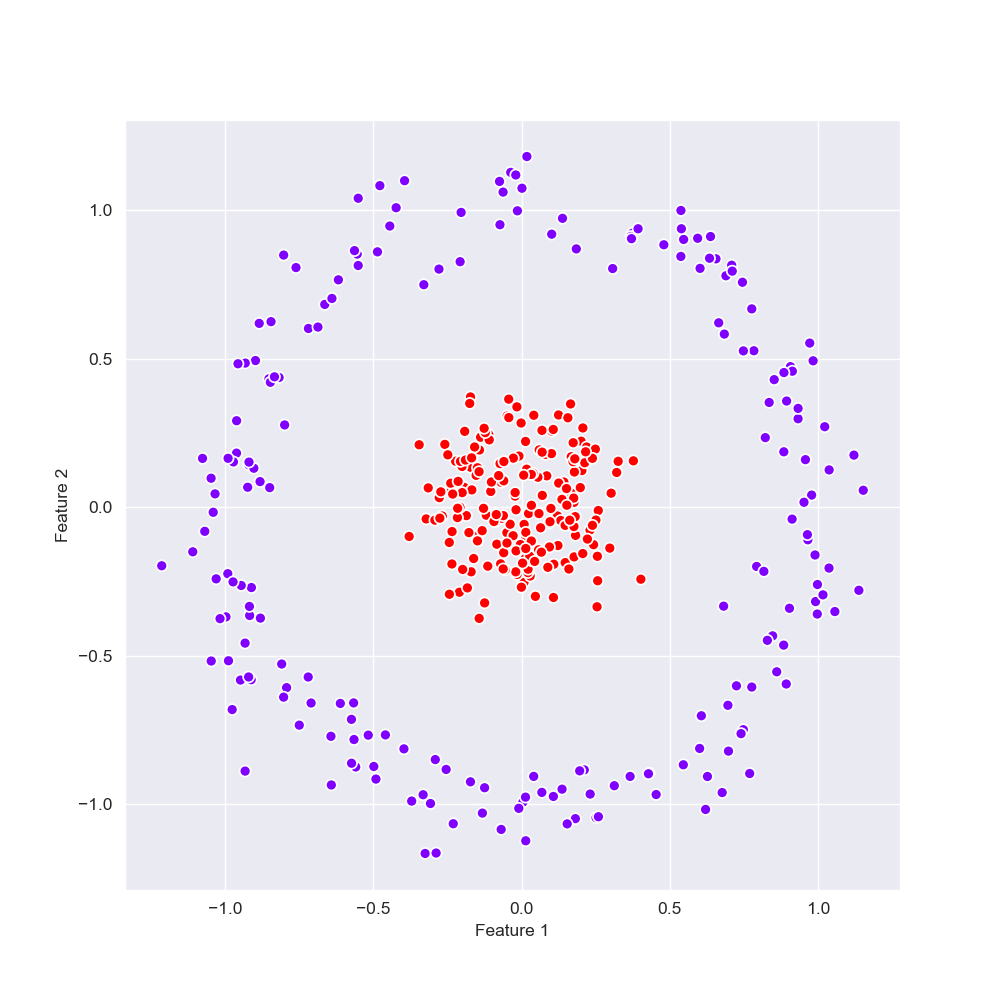

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets.samples_generator import make_circles
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# generate data set
# noise gives the standard deviation of Gaussian noise
# factor gives the scale factor between the inner and outer circles
X, y = make_circles(500, factor = 0.2, noise = 0.1, random_state = 8)

# split the data in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=12)

# plot data
sns.set_style('darkgrid')
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax.scatter(X_train[:,0], X_train[:,1], c = y_train, cmap = 'rainbow', s = 40,
           edgecolors = 'white')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

We can see that in this two-dimensional plane it is not possible to insert a one-dimensional line (the hyperplane) to separate the y=0 (purple) and y=1 (red) samples. Therefore, we use the RBF kernel to project the data into a third dimension. As the data is conveniently centred about the origin we can use the origin as a 'landmark'. In this fashion the RBF will return larger values for those points nearest to the origin than for those further away.

<IPython.core.display.Javascript object>


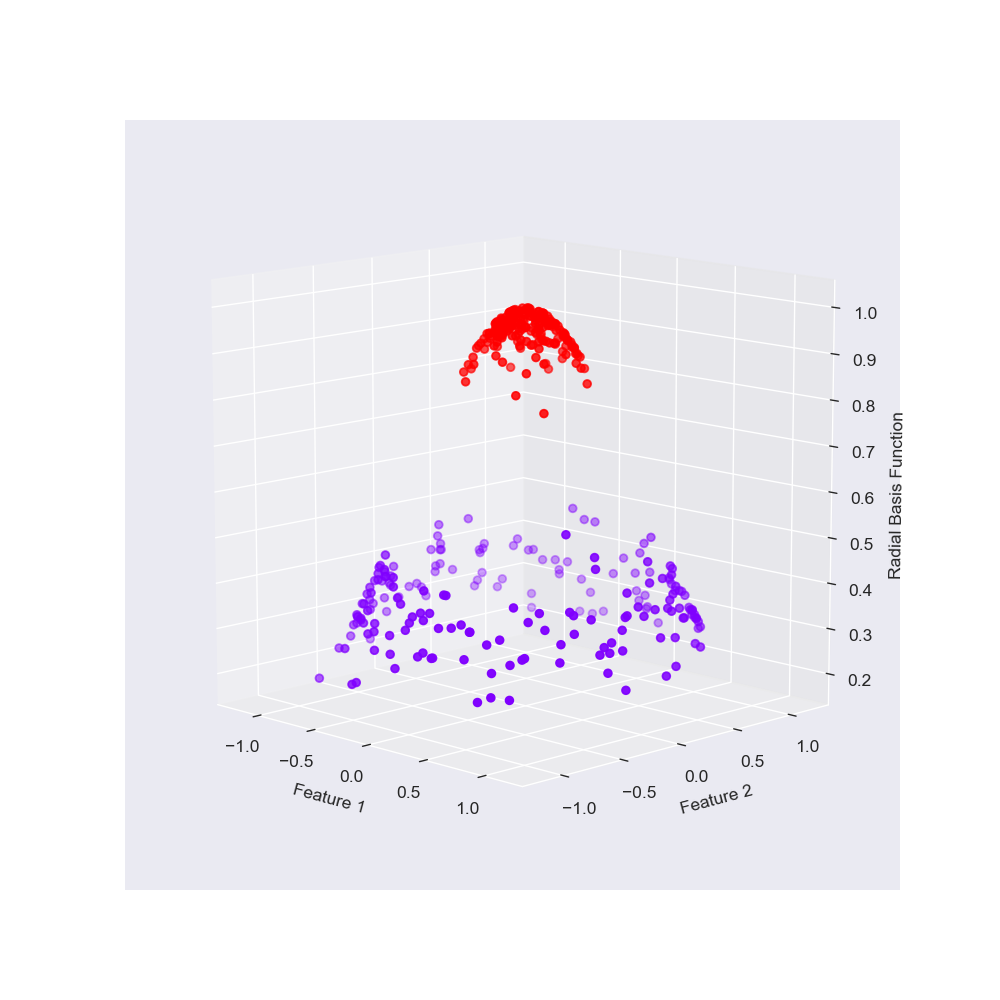

In [47]:
sigma = 1/np.sqrt(2)
# define RBF function
# we have used f(X) = exp((-|X - 0|^2)/(2*sigma^2)), where 0 denotes the origin.
rbf = np.exp(-abs(X_train[:,0]**2 + X_train[:,1]**2)/(2*sigma**2))

# plot three-dimensional data
fig2 = plt.figure(figsize = (8, 8))
ax2 = fig2.add_subplot(111, projection = '3d')
ax2.scatter(X_train[:,0], X_train[:,1], rbf, c = y_train, cmap = 'rainbow')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Radial Basis Function')
plt.show()

After the projection into three dimensions we can see that the data is now linearly separable with a two-dimensional plane. We will now proceed to fit an SVM classifier to this data and plot the hyperplane. 

In [48]:
# create SVM classifier with minimal regularisation
svc = SVC(kernel='linear', C = 1e6)
# use the rbf values as the Z coordinates of the points in X_train
X_3d = np.hstack([X_train, rbf.reshape(400, 1)])
# train the SVM classifier on the new 3D data
svc.fit(X_3d, y_train)
coefs = svc.coef_[0]
intercept = svc.intercept_[0]

To plot the hyperplane we will need to generate a grid of coordinates and calculate the hyperlane equation from the retrieved coefficients and intercept.

<IPython.core.display.Javascript object>


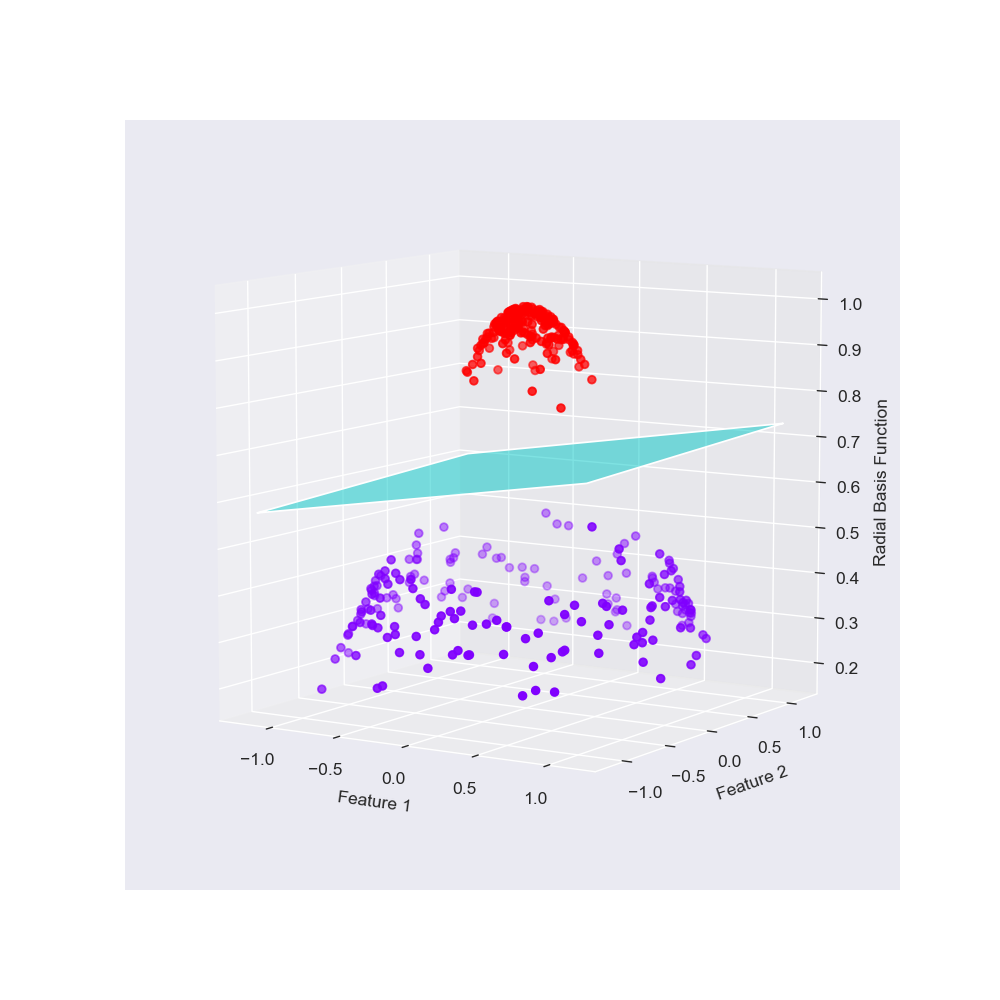

In [49]:
x1_min = min(X_train[:,0])
x1_max = max(X_train[:,0])
x2_min = min(X_train[:,1])
x2_max = max(X_train[:,1])
x1 = np.linspace(x1_min, x1_max, 100)
x2 = np.linspace(x2_min, x2_max, 100)
# generate a grid of x and y points
X1, X2 = np.meshgrid(x1, x2)
# decision boundary equation is given by w.x + b = 0, where w and x are vectors
# In 3D w1*x1 + w2*x2 + w3*x3 + b = 0, therefore x3 = (-b - w1*x1 - w2*x2)/w3
Z = (-intercept - coefs[0]*X1 - coefs[1]*X2)/coefs[2]

# plot data and hyperplane
fig3 = plt.figure(figsize = (8, 8))
ax3 = fig3.add_subplot(111, projection = '3d')
ax3.scatter(X_train[:,0], X_train[:,1], rbf, c = y_train, cmap = 'rainbow')
ax3.set_xlabel('Feature 1')
ax3.set_ylabel('Feature 2')
ax3.set_zlabel('Radial Basis Function')
ax3.plot_surface(X1, X2, Z, color = 'cyan', alpha = 0.5, rstride=100, cstride=100)
plt.show()

Now we have seen how the RBF kernel works under the hood in an SVM problem, we will employ it directly when training a classifier on the data.

In [50]:
# generate SV classifier with RBF kernel and minimal regularisation
svc2 = SVC(kernel = 'rbf', C=1e6, gamma = 'auto')
svc2.fit(X_train, y_train)
# predict y_test
y_pred = svc2.predict(X_test)
# generate confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[47  0]
 [ 0 53]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        53

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



Model performance is perfect for this simple dataset. Finally, we wish to plot the hyperplane on the original two-dimensional plot. We go about this by taking the grid of points created earlier and passing it to decision_function which determines the side of the hyperplane each point lies on and the distance to the hyperplane. In this fashion the location of the hyperplane can be identified. We can then use a contour plot to visualise the hyperplane and margins.

<IPython.core.display.Javascript object>


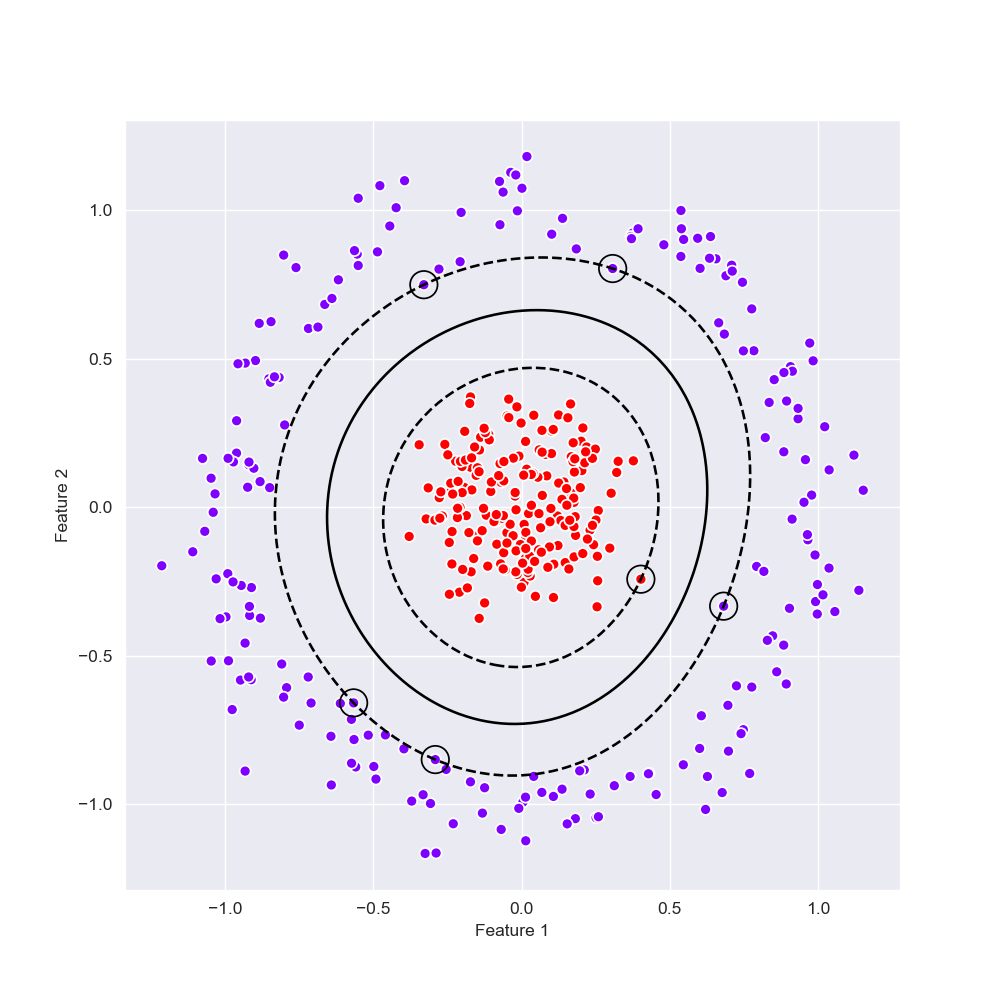

In [51]:
# arrange grid into a format that can be accepted by sklearn
# unravel X1 and Y1 into 1D arrays ans vertically stack them
points = np.vstack([X1.ravel(), X2.ravel()]).T
# # evaluate the decision function for 'points' and reshape to shape of original grid
boundary = svc2.decision_function(points).reshape(X1.shape)

# plot data, hyperplane and margins
fig4 = plt.figure(figsize = (8, 8))
ax4 = fig4.add_subplot(111)
# SVM boundary occurs at w*x+b=0
# margins occur at w*x+b=1 and w*x+b=-1
# these are represented by the contour levels
ax4.scatter(X_train[:,0], X_train[:,1], c = y_train, cmap = 'rainbow', s = 40,
           edgecolors = 'white')
ax4.set_xlabel('Feature 1')
ax4.set_ylabel('Feature 2')
ax4.contour(X1, X2, boundary, colors = 'k', levels = [-1, 0, 1],
           linestyles = ['--', '-', '--'])

# get support vectors
support_vecs = svc2.support_vectors_
# plot support vectors
ax4.scatter(support_vecs[:,0], support_vecs[:,1], s = 250, linewidth = 1,
           facecolors = 'none', edgecolors = 'k')
plt.show()
